### Custom kernels

Let's say you don't want to be stuck with vanilla quasi-periodic Gaussian Process kernels to describe your correlated noise. We want to be agnostic about your noise so that we can generalize to diverse science use cases, after all! 

Enter: tinygp (https://tinygp.readthedocs.io/en/stable/; Dan Foreman-Mackey and friends). We provide an interface with tinygp -- simply define your correlated noise kernel in tinygp, and then pass the kernel object into the gaspery covariance matrix class.

In [1]:
import numpy as np 
import scipy
print(np.__version__)
print(scipy.__version__)
import pandas as pd
import random
import exoplanet
import astropy 
import pymc3
import pymc3_ext
import tinygp
from tinygp import kernels, GaussianProcess
from numpy.linalg import inv, det, solve, cond
from tqdm import tqdm
from astropy.time import Time

import matplotlib.pyplot as plt
import matplotlib

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
#from jax import random

from gaspery import calculate_fi, strategies, utils



1.22.3
1.7.3


In [2]:
import matplotlib.pylab as pylab
pylab_params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(pylab_params)

path = '/Users/chrislam/Desktop/gaspery/'

List Planet Class parameters 

In [4]:
### Planet parameters
p = 8.46 # orbital period, days
K = 850 # cm/s
T0 = 2458651.993 # central transit time, in BJD, on 19 June 2019

### choose start time as date of this writing
start = '2023-03-01T10:00:00'
start = Time(start, format='isot', scale='utc').jd

List Star Class parameters, but these won't necessarily go into a quasiperiodic GP kernel.

In [5]:
### correlated noise parameters, from Klein+ 2021 for AU Mic
Prot = 4.86 # rotation period, days
Tau = 100/np.sqrt(2) # active region lifetime; days
eta = 0.4/np.sqrt(2) # 0.1, 0.3, 0.58, 0.9 # smoothing parameter
sigma_qp_rv = 47 # modified Jeffreys prior +11, -8 [m/s]
sigma_wn_rv = 5 # photon noise level [m/s]

params = [sigma_wn_rv, Tau, eta, Prot, sigma_qp_rv]
theta = [K, p, T0]

Define an observing strategy

In [10]:
# build strategy aka time series of observations
cadence = 1 # observe once a day every day
n_obs = 30
strategy = strategies.Strategy(n_obs = n_obs, start = start, offs=[], dropout=0.)
strat = strategy.gappy(cadence)

#### Define a custom kernel with tinygp

Here we re-invent the wheel by custom defining a quasi-periodic kernel. But you can imagine truly going wild with your own kernel, if your use case calls for going beyond what the tinygp toolkit gives you!

In [12]:
class Quasiperiodic(tinygp.kernels.Kernel):
    
    def __init__(self, Tau, eta, Prot, sigma_qp_rv):
        self.sigma_wn_rv = sigma_wn_rv
        self.Tau = Tau
        self.eta = eta
        self.Prot = Prot
        self.sigma_qp_rv = sigma_qp_rv

    def evaluate(self, X1, X2):
        tdiff = jnp.abs(X1 - X2) 
        term1 = (tdiff**2) / (2*self.Tau**2)
        term2 = (1/(2*self.eta**2)) * (jnp.sin(jnp.pi * (tdiff)/self.Prot))**2
        arg = -term1 - term2
        k = jnp.exp(arg)
        K = self.sigma_qp_rv**2 * k
        return K
            

def build_gp(params, strat):

    kernel = Quasiperiodic(
        params[1], params[2], params[3], params[4] # omit the first param, which is for white noise and will be applied later
    )

    return kernel

# instantiate kernel object
kernel = build_gp(params, strat)

# call kernel on observation strategy time series to get covariance matrix with correlated noise terms only
k = kernel(strat, strat)

# add white noise to correlated noise kernel
k = k * sigma_wn_rv**2 * jnp.diag(np.ones(len(strat)))
k += 1e-6 




In [23]:
sigma_ks_qp = []
for n_obs in tqdm(range(100)[4:]):
    
    # instantiate Star object in order to feed covariance matrix with white/correlated noise
    star = calculate_fi.Star(sigma_wn_rv = sigma_wn_rv, Tau = Tau, eta = eta, 
                             Prot = Prot, sigma_qp_rv = sigma_qp_rv)
    
    # populate list of parameters to feed into cov_matrix_jax()
    params = star.param_list()
    
    # instantiate Planets object in order to feed Fisher Info calculation machinery
    planet = calculate_fi.Planets(K = K, p = p, T0 = T0)
    
    # populate list of parameters to feed into clam_jax_fim()
    theta = planet.theta_list()
    
    # instantiate Strategy object in order to build time series of observations
    strategy = strategies.Strategy(n_obs = n_obs, start = start, offs=[], dropout=0.)
    
    # build strategy aka time series of observations
    strat = strategy.gappy(cadence)
    
    # build covariance matrix, characterized by a custom quasi-periodic noise model of the stellar signal
    kernel = build_gp(params, strat)
    
    #sigma = calculate_fi.cov_matrix_jax(strat, params) # non-object-oriented
    #sigma = star.cov_matrix(strat) # object-oriented but w/manual QP GP kernel
    sigma = star.cov_matrix_general(strat, kernel) # object-oriented with custom kernels
    sigma += 1e-6 

    # populate arguments for Fisher Info calculator
    args = np.array(strat), sigma, jnp.array(theta, dtype=float)
    
    # calculate FI
    fim = calculate_fi.clam_jax_fim(*args).block_until_ready()
    
    # invert FI matrix
    inv_fim = inv(fim)
    
    # top left element of matrix corresponds with RV semi-amplitude, K
    sigma_k = np.sqrt(inv_fim)[0][0]
    
    sigma_ks_qp.append(sigma_k)
    

  0%|                                                                          | 0/96 [00:00<?, ?it/s]/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_88168/2798112378.py:41: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
100%|████████████████████████████████████████████████████████████████| 96/96 [00:00<00:00, 187.71it/s]


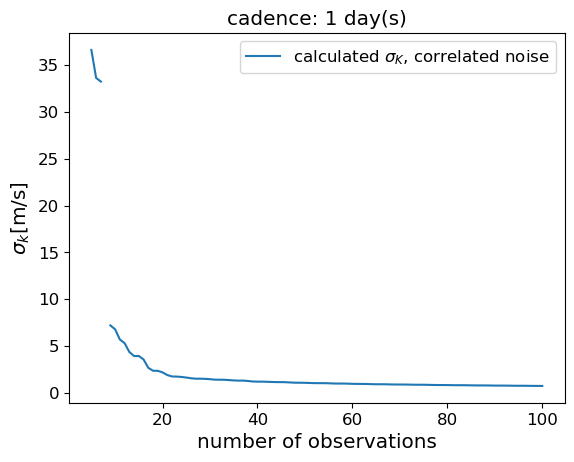

In [24]:
plt.plot(np.arange(len(sigma_ks_qp))+5, sigma_ks_qp, label='calculated $\sigma_K$, correlated noise')
plt.xlabel('number of observations')
plt.ylabel(r"$\sigma_k$[m/s]")
plt.title(f"cadence: {cadence} day(s)")
plt.legend()
#plt.ylim([0,200])
plt.show()

And again with an out-of-the-box quasi-periodic GP kernel from tinygp. 

In [19]:
sigma_ks_qp = []
for n_obs in tqdm(range(100)[4:]):
    
    # instantiate Star object in order to feed covariance matrix with white/correlated noise
    star = calculate_fi.Star(sigma_wn_rv = sigma_wn_rv, Tau = Tau, eta = eta, 
                             Prot = Prot, sigma_qp_rv = sigma_qp_rv)
    
    # populate list of parameters to feed into cov_matrix_jax()
    params = star.param_list()
    
    # instantiate Planets object in order to feed Fisher Info calculation machinery
    planet = calculate_fi.Planets(K = K, p = p, T0 = T0)
    
    # populate list of parameters to feed into clam_jax_fim()
    theta = planet.theta_list()
    
    # instantiate Strategy object in order to build time series of observations
    strategy = strategies.Strategy(n_obs = n_obs, start = start, offs=[], dropout=0.)
    
    # build strategy aka time series of observations
    strat = strategy.gappy(cadence)
    
    # build covariance matrix, characterized by a correlated noise model of the stellar signal
    kernel = kernels.ExpSineSquared(scale=Prot, gamma=1/(2*eta**2)) # first term of exponential
    kernel *= kernels.ExpSquared(scale=Tau) # other term of exponential
    kernel *= sigma_qp_rv**2 # multiply by scalar
    
    #sigma = calculate_fi.cov_matrix_jax(strat, params) # non-object-oriented
    #sigma = star.cov_matrix(strat) # object-oriented but w/manual QP GP kernel
    sigma = star.cov_matrix_general(strat, kernel) # object-oriented with custom kernels
    sigma += 1e-6 

    #print(strat, sigma)
    #fadsfa
    
    # populate arguments for Fisher Info calculator
    args = np.array(strat), sigma, jnp.array(theta, dtype=float)
    
    # calculate FI
    fim = calculate_fi.clam_jax_fim(*args).block_until_ready()
    
    # invert FI matrix
    inv_fim = inv(fim)
    
    # top left element of matrix corresponds with RV semi-amplitude, K
    sigma_k = np.sqrt(inv_fim)[0][0]
    
    sigma_ks_qp.append(sigma_k)
    

  0%|                                                                          | 0/96 [00:00<?, ?it/s]/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_88168/241485815.py:46: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
100%|█████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 16.13it/s]


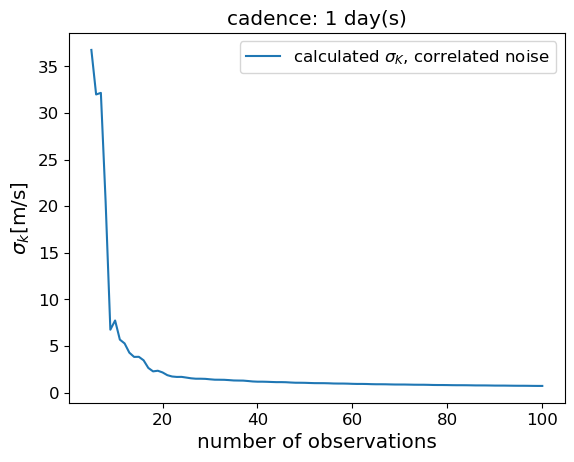

In [22]:
plt.plot(np.arange(len(sigma_ks_qp))+5, sigma_ks_qp, label='calculated $\sigma_K$, correlated noise')
plt.xlabel('number of observations')
plt.ylabel(r"$\sigma_k$[m/s]")
plt.title(f"cadence: {cadence} day(s)")
plt.legend()
#plt.ylim([0,200])
plt.show()

Except for a dropped point where the covariance matrix based on the custom kernel is singular (and thus can't be inverted), the custom quasi-periodic Gaussian Process kernel matches the result from the out-of-the-box quasi-periodic GP kernel.